# Feature Selection

### Loading our data

In [1]:
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import numpy as np

df = pd.read_csv('df2.csv')

X = df.drop(columns=['Unnamed: 0', 'prices.amountMax'])
y = df['prices.amountMax']

X_train, X, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [2]:
X_train.shape

(3428, 102)

In [3]:
X.shape

(1072, 102)

In [4]:
X_val.shape

(857, 102)

In [5]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 35, max_features='log2').fit(X_train, y_train)

In [6]:
rfr.score(X_val, y_val)

0.5770258444582641

### 1. Working with Feature Importances

In [7]:
importance_numbers = rfr.feature_importances_

In [8]:
importance_list = importance_numbers.tolist()

In [9]:
X.columns

Index(['prices.isSale', 'prices.dateSeenYear', 'prices.dateSeenMonth',
       'prices.dateSeenWeek', 'prices.dateSeenDay', 'prices.dateSeenDayofweek',
       'prices.dateSeenDayofyear', 'prices.dateSeenIs_month_end',
       'prices.dateSeenIs_month_start', 'prices.dateSeenIs_quarter_end',
       ...
       'colors_Multicolor', 'colors_Pink', 'colors_Red', 'colors_Silver',
       'colors_White', 'colors_nan_value', 'colors_other',
       'prices.currency_AUD', 'prices.currency_CAD', 'prices.currency_USD'],
      dtype='object', length=102)

In [10]:
importances = np.vstack((X.columns, importance_list))

In [11]:
importances = pd.Series(importance_list, index = X.columns)

In [12]:
importances[importances>0.01].shape

(27,)

* The number of the features whose importance values are larger than .01, is 27.

In [13]:
Important = X.columns[importances>0.01]

In [14]:
X_importances_train = X_train[Important]

In [15]:
X_importances_val = X_val[Important]

In [16]:
X_importances_train.shape

(3428, 27)

In [17]:
X_importances_val.shape

(857, 27)

In [18]:
rfr_importances = RandomForestRegressor(n_estimators = 40, max_features='log2').fit(X_importances_train, y_train)

In [19]:
rfr_importances.score(X_importances_val, y_val)

0.5315595834247

Here, we can see that using the feature importances did not exactly provide us with a cutoff number, and increase our accuracy.

### 2. Working with Permutation Importance

In [20]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 40, max_features='log2')
rfr.fit(X_train, y_train)
rfr.score(X_val, y_val)

0.5777096037982281

Now that we have trained our model, it's time to select some features from the model.  We start by using our `PermutationImportance` transformer.

In [21]:
import eli5

In [22]:
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rfr).fit(X_val, y_val)

> And then we view the importances.

In [23]:
eli5.explain_weights_df(perm, feature_names = X_val.columns.to_list()).head(5)

,feature,weight,std
0,prices.isSale,0.301369,0.017391
1,categories_Boots,0.028634,0.003665
2,categories_Slippers,0.015874,0.001687
3,brand_Dansko,0.015483,0.001242
4,brand_other,0.012488,0.004773


Now, to select the features, we could simply select the features from the dataframe.  Another mechanism is to use the `SelectFromModel` transformer from sklearn.

In [24]:
from sklearn.feature_selection import SelectFromModel
first_selection = SelectFromModel(perm, threshold=0.005, prefit=True)
X_val_first_select = first_selection.transform(X_val)
X_train_first_select = first_selection.transform(X_train)

At the beginning we select the all 102 features. Then we retrain the model with just features beyond .005 and see how it performs.  

In [25]:
rfr_first_select = RandomForestRegressor(n_estimators=40, max_features='log2')
rfr_first_select.fit(X_train_first_select, y_train)
rfr_first_select.score(X_val_first_select, y_val)

0.5658769952381899

Here, we see an increase in performance from our model.  We can determine which features were selected with the `get_support` method.

In [26]:
first_select_cols = X_train.columns[first_selection.get_support()]
first_select_cols

Index(['prices.isSale', 'prices.dateSeenElapsed', 'brand_Dansko', 'brand_Nike',
       'brand_Ugg', 'brand_other', 'manufacturer_Nike',
       'manufacturerNumber_other', 'prices.merchant_Shoes.com',
       'categories_Athletic', 'categories_Boots', 'categories_Sandals',
       'categories_Slip-ons', 'categories_Slippers', 'categories_other',
       'colors_Green', 'colors_nan_value'],
      dtype='object')

In [27]:
first_select_cols.shape

(17,)

Round two

Now that we are only selecting thirty eight columns, and some of the features were collinear with others, if we look at feature importances we are sure to see some changes.  Let's call `PermutationImportance` again just with these features.

In [28]:
from eli5.sklearn import PermutationImportance
second_pmi = PermutationImportance(rfr_first_select).fit(X_val_first_select, y_val)

In [29]:
eli5.explain_weights_df(second_pmi, top=10, feature_names = first_select_cols.to_list())

,feature,weight,std
0,prices.isSale,0.396160,0.020308
1,prices.dateSeenElapsed,0.281447,0.011757
2,brand_other,0.167439,0.010576
3,categories_other,0.111436,0.012583
4,brand_Dansko,0.076253,0.004496
5,categories_Boots,0.074275,0.008252
6,brand_Ugg,0.073363,0.003695
7,categories_Athletic,0.062089,0.007250
8,categories_Slip-ons,0.055433,0.003924
9,categories_Slippers,0.042482,0.004750


So we can see that prices.isSale count now has a weight near .39, up from it's previous score of .09.  On the other side, we also have features that no longer make our one percent weight cutoff.

In [30]:
eli5.explain_weights_df(second_pmi, feature_names = first_select_cols.to_list()).tail(5)

,feature,weight,std
12,manufacturer_Nike,0.018960,0.002471
13,colors_nan_value,0.011060,0.003765
14,categories_Sandals,0.009913,0.003066
15,prices.merchant_Shoes.com,0.008995,0.002737
16,brand_Nike,0.002388,0.001239


So let's select from our model again.

In [31]:
second_select = SelectFromModel(second_pmi, threshold=0.01, prefit=True)
X_train_second_select = second_select.transform(X_train_first_select)
X_val_second_select = second_select.transform(X_val_first_select)

rfr_second_select = RandomForestRegressor(n_estimators=40, max_features='log2')
rfr_second_select.fit(X_train_second_select, y_train)
rfr_second_select.score(X_val_second_select, y_val)

0.5601169165449147

And again.

In [32]:
third_pmi = PermutationImportance(rfr_second_select).fit(X_val_second_select, y_val)
third_select = SelectFromModel(third_pmi, threshold=0.01, prefit=True)

X_train_third_select = third_select.transform(X_train_second_select)
X_val_third_select = third_select.transform(X_val_second_select)

rfr_third_select = RandomForestRegressor(n_estimators=40, max_features='log2')
rfr_third_select.fit(X_train_third_select, y_train)
rfr_third_select.score(X_val_third_select, y_val)

0.5556765896967703

In [33]:
second_select_cols = first_select_cols[second_select.get_support()]
third_select_cols = second_select_cols[third_select.get_support()]
third_select_cols.shape

(14,)

In [34]:
eli5.explain_weights_df(third_pmi, feature_names = second_select_cols.to_list())

,feature,weight,std
0,prices.isSale,0.366877,0.014884
1,prices.dateSeenElapsed,0.338579,0.025123
2,brand_other,0.164640,0.016674
3,categories_other,0.123573,0.022912
4,brand_Ugg,0.070968,0.008322
5,brand_Dansko,0.069838,0.004791
6,categories_Boots,0.063177,0.007665
7,categories_Athletic,0.045831,0.003270
8,categories_Slippers,0.038395,0.003174
9,manufacturerNumber_other,0.035802,0.002862


And again.

In [35]:
fourth_pmi = PermutationImportance(rfr_third_select).fit(X_val_third_select, y_val)
fourth_select = SelectFromModel(fourth_pmi, threshold=0.01, prefit=True)

X_train_fourth_select = fourth_select.transform(X_train_third_select)
X_val_fourth_select = fourth_select.transform(X_val_third_select)

rfr_fourth_select = RandomForestRegressor(n_estimators=40, max_features='log2')
rfr_fourth_select.fit(X_train_fourth_select, y_train)
rfr_fourth_select.score(X_val_fourth_select, y_val)

0.5614794262767551

In [36]:
third_select_cols = second_select_cols[third_select.get_support()]
fourth_select_cols = third_select_cols[fourth_select.get_support()]
fourth_select_cols.shape

(13,)

In [37]:
eli5.explain_weights_df(fourth_pmi, feature_names = third_select_cols.to_list())

,feature,weight,std
0,prices.isSale,0.379113,0.025581
1,prices.dateSeenElapsed,0.322318,0.027204
2,brand_other,0.169531,0.017784
3,categories_other,0.113063,0.009195
4,brand_Dansko,0.104862,0.005855
5,categories_Boots,0.087794,0.012794
6,brand_Ugg,0.068031,0.004230
7,categories_Athletic,0.048411,0.007695
8,categories_Slippers,0.036771,0.002879
9,manufacturer_Nike,0.027604,0.003949


The score doesn't go up after this round. So from here, we can begin to identify the most important features.

In [38]:
selected_X_train = pd.DataFrame(X_train_fourth_select, columns=fourth_select_cols)
selected_X_val = pd.DataFrame(X_val_fourth_select, columns=fourth_select_cols)

In [39]:
fourth_select_cols

Index(['prices.isSale', 'prices.dateSeenElapsed', 'brand_Dansko', 'brand_Ugg',
       'brand_other', 'manufacturer_Nike', 'manufacturerNumber_other',
       'categories_Athletic', 'categories_Boots', 'categories_Slip-ons',
       'categories_Slippers', 'categories_other', 'colors_Green'],
      dtype='object')

### 3. Correlation Analysis

#### Working with Spearman Correlation

In [40]:
selected_X_train = selected_X_train.astype('int32')
selected_X_val = selected_X_val.astype('int32')

In [41]:
import numpy as np
indexed_corr = (np.abs(selected_X_train.corr(method = 'spearman')) > .5).sum()
correlated_cols = indexed_corr[indexed_corr > 1].index
correlated_cols

Index(['brand_Dansko', 'manufacturerNumber_other', 'categories_Slip-ons',
       'categories_other'],
      dtype='object')

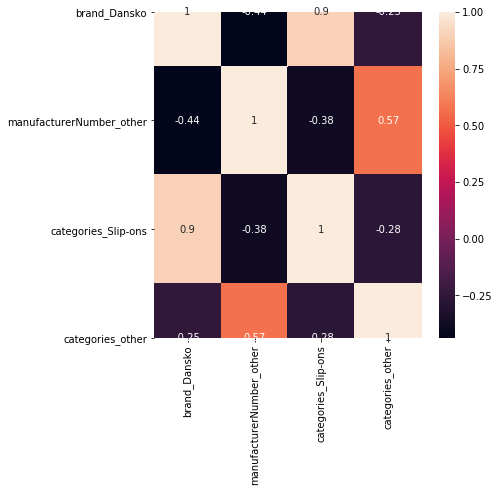

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
df_corr = selected_X_train[correlated_cols].corr(method = 'spearman')
sns.heatmap(df_corr, annot = True)

From here we can identify those features that are highly correlated. The lighter the color, the higher the correlation.

* 'brand_Dansko', 'categories_Slip-ons'
* 'manufacturerNumber_other', 'categories_other'

#### a) 'brand_Dansko', 'categories_Slip-ons'

If we try various permutations of removing one or more of our availability features, to see if we suffer a significant from from our original score of .831. We find scores like the following:
* remove `brand_Dansko`: 0.560
* remove `categories_Slip-ons`: 0.564

They are almost the same.  I prefer remove categories_Slip-ons.

In [44]:
df_dropped_brand_Dansko_train = selected_X_train.drop(columns = ['brand_Dansko'])
df_dropped_brand_Dansko_val = selected_X_val.drop(columns = ['brand_Dansko'])

rfr_dropped_brand_Dansko = RandomForestRegressor(n_estimators=40, max_features='log2')
rfr_dropped_brand_Dansko.fit(df_dropped_brand_Dansko_train, y_train)
rfr_dropped_brand_Dansko.score(df_dropped_brand_Dansko_val, y_val)

0.5606915962634698

In [45]:
df_dropped_categories_Slip_ons_train = selected_X_train.drop(columns = ['categories_Slip-ons'])
df_dropped_categories_Slip_ons_val = selected_X_val.drop(columns = ['categories_Slip-ons'])

rfr_dropped_categories_Slip_ons = RandomForestRegressor(n_estimators=40, max_features='log2')
rfr_dropped_categories_Slip_ons.fit(df_dropped_categories_Slip_ons_train, y_train)
rfr_dropped_categories_Slip_ons.score(df_dropped_categories_Slip_ons_val, y_val)

0.5642189681732557

#### b) 'prices.merchant_Walmart', 'categories_other'

 `categories_other` and `manufacturerNumber_other` are neither informative
 
* remove `categories_other`: 0.567
* remove `manufacturerNumber_other`: 0.562

So I drop `categories_other` for a higher score.

In [54]:
train_drop_categories_other = df_dropped_categories_Slip_ons_train.drop(columns = ['categories_other'])
val_drop_categories_other = df_dropped_categories_Slip_ons_val.drop(columns = ['categories_other'])
rfr_dropped_categories_other = RandomForestRegressor(n_estimators=40, max_features='log2')

rfr_dropped_categories_other.fit(train_drop_categories_other, y_train)
rfr_dropped_categories_other.score(val_drop_categories_other, y_val)

0.567091195301141

In [55]:
train_drop_manufacturerNumber_other = df_dropped_categories_Slip_ons_train.drop(columns = ['manufacturerNumber_other'])
val_drop_manufacturerNumber_other = df_dropped_categories_Slip_ons_val.drop(columns = ['manufacturerNumber_other'])
rfr_dropped_manufacturerNumber_other = RandomForestRegressor(n_estimators=40, max_features='log2')

rfr_dropped_manufacturerNumber_other.fit(train_drop_manufacturerNumber_other, y_train)
rfr_dropped_manufacturerNumber_other.score(val_drop_manufacturerNumber_other, y_val)

0.5628136404384981

In [56]:
train_drop_categories_other.shape

(3428, 11)

After the correlation analysis, we remove two features, then we get score .567 . Not bad.

At the beginning we apply 102 features to score .56 . Now we use only 11 features.

#### Working with Scatter Plots

scatter matrix


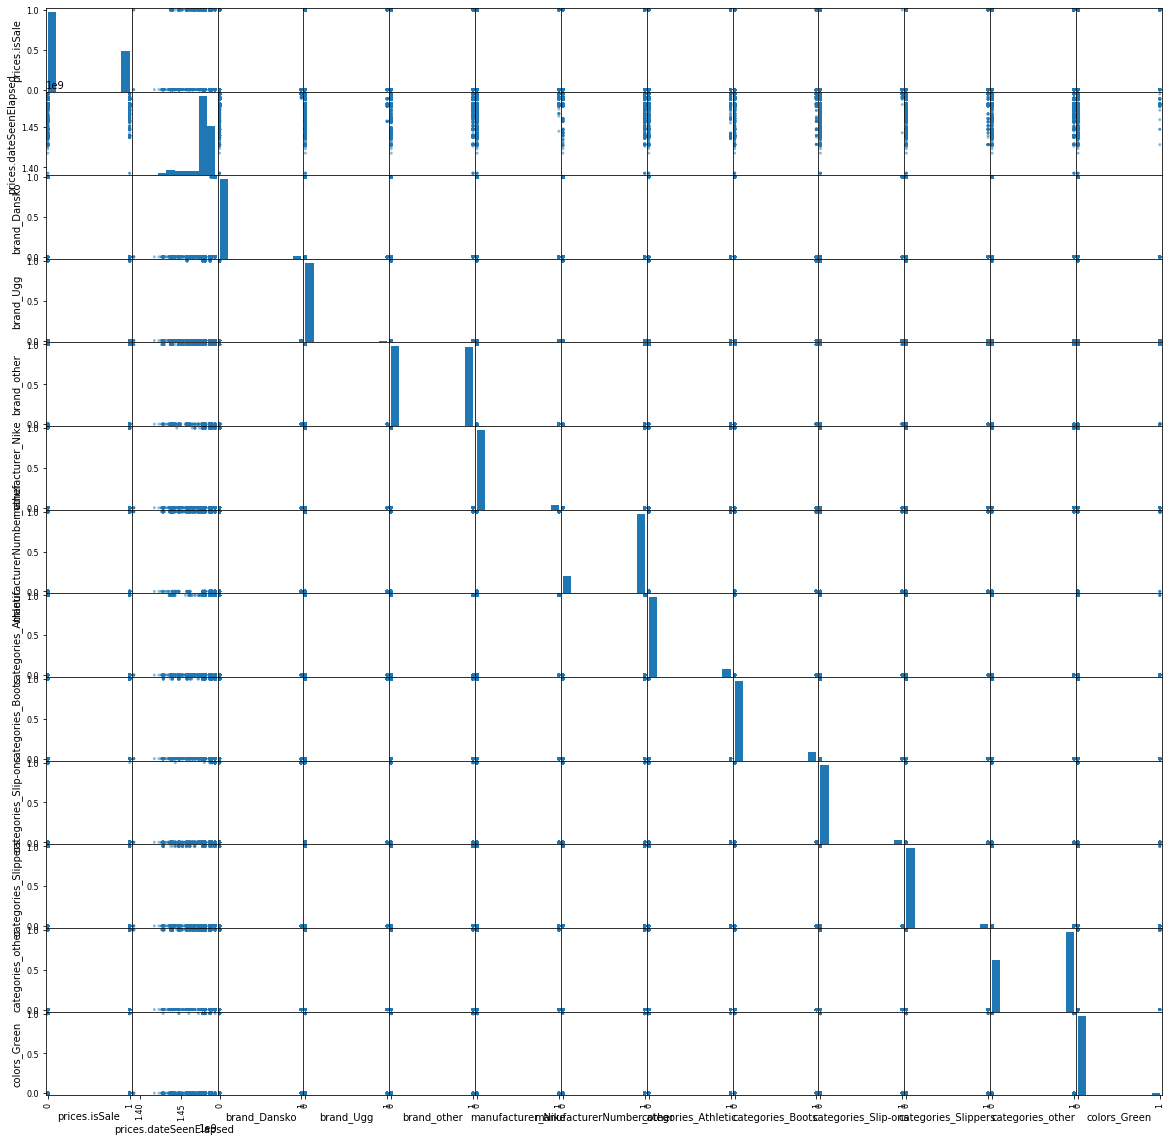

In [57]:
pd.plotting.scatter_matrix(selected_X_train, figsize=(20,20))
print('scatter matrix')

Although we can not tell the feature names in the graph, but we can see, the correlation maps are either spot or line. So it concludes that not any two of the features have high correlation in this graph.
But as we see in spearson correlation analysis, some of them have correlation like .9, but we can not discover it here.

In [58]:
selected_X_train.corr(method = 'pearson')

,prices.isSale,prices.dateSeenElapsed,brand_Dansko,brand_Ugg,brand_other,manufacturer_Nike,manufacturerNumber_other,categories_Athletic,categories_Boots,categories_Slip-ons,categories_Slippers,categories_other,colors_Green
prices.isSale,1.000000,-0.084094,-0.143868,0.032033,0.195032,-0.079268,0.231918,-0.181022,-0.110105,-0.156999,-0.082487,0.348756,0.044377
prices.dateSeenElapsed,-0.084094,1.000000,0.201446,0.001720,-0.135989,0.084033,-0.217906,0.056932,0.129051,0.216032,-0.108949,-0.156670,-0.002492
brand_Dansko,-0.143868,0.201446,1.000000,-0.028040,-0.200637,-0.046921,-0.436997,-0.064941,-0.068013,0.899795,-0.041773,-0.249776,-0.029751
brand_Ugg,0.032033,0.001720,-0.028040,1.000000,-0.138297,-0.032343,-0.301218,-0.044763,0.412281,-0.031163,-0.028794,-0.172168,-0.020507
brand_other,0.195032,-0.135989,-0.200637,-0.138297,1.000000,-0.231420,0.459126,-0.212298,-0.190923,-0.195644,-0.015071,0.380713,0.051292
manufacturer_Nike,-0.079268,0.084033,-0.046921,-0.032343,-0.231420,1.000000,0.107373,0.491453,-0.078448,-0.052147,-0.048183,-0.152885,-0.034316
manufacturerNumber_other,0.231918,-0.217906,-0.436997,-0.301218,0.459126,0.107373,1.000000,0.148607,-0.472335,-0.377897,-0.136040,0.571574,0.052149
categories_Athletic,-0.181022,0.056932,-0.064941,-0.044763,-0.212298,0.491453,0.148607,1.000000,-0.108574,-0.072173,-0.066686,-0.398738,-0.019789
categories_Boots,-0.110105,0.129051,-0.068013,0.412281,-0.190923,-0.078448,-0.472335,-0.108574,1.000000,-0.075587,-0.069841,-0.417599,-0.049741
categories_Slip-ons,-0.156999,0.216032,0.899795,-0.031163,-0.195644,-0.052147,-0.377897,-0.072173,-0.075587,1.000000,-0.046425,-0.277592,-0.033065


* From the chart, we can find the .89 between brand_Dansko and categories_Slip-ons.

#### Working with Dendrograms

Wall time: 272 ms


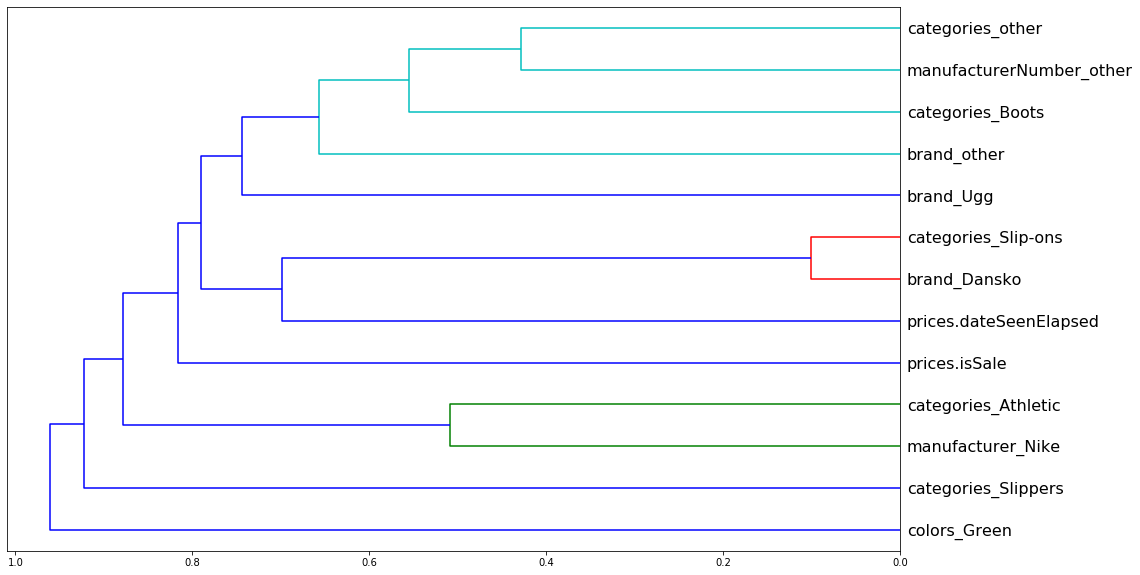

In [59]:
%%time
import scipy.cluster.hierarchy as hc
corr = selected_X_train.corr(method = 'spearman')
corr_condensed = hc.distance.squareform(1 - np.abs(corr))
z = hc.linkage(corr_condensed, method = 'average')

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels = list(selected_X_train.columns), orientation = 'left', leaf_font_size=16)

Looking at the dendrogram above, the result matches the spearman method. We should either remove either `brand_Dansko` or  `categories_Slip-ons`, either `manufacturerNumber_other` or `categories_other`.

* The result after removing these features should be the same as spearman method does.

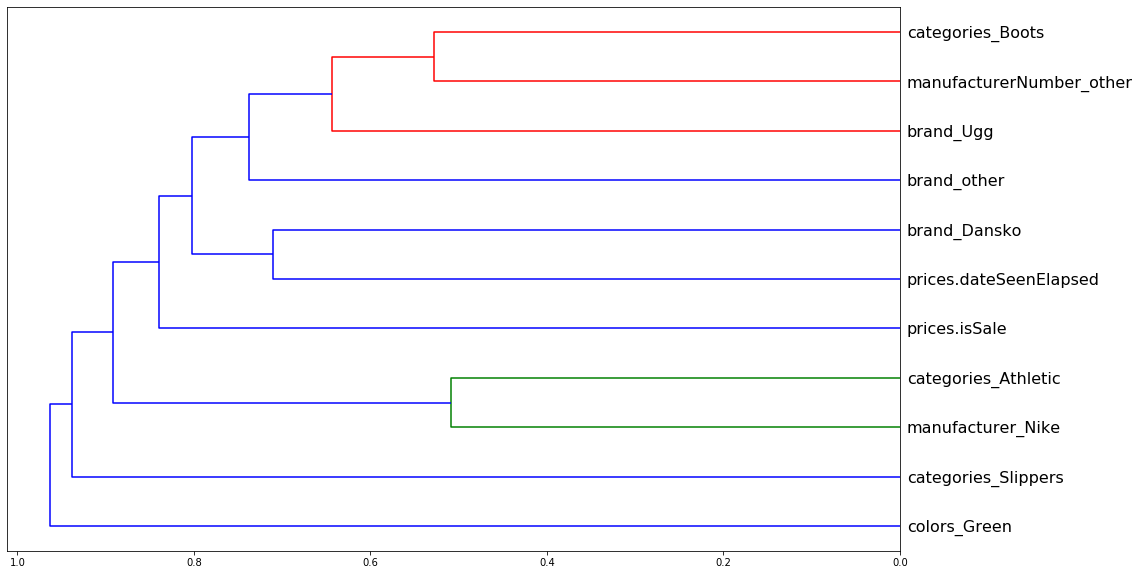

In [60]:
import scipy.cluster.hierarchy as hc
corr = train_drop_categories_other.corr(method = 'spearman')
corr_condensed = hc.distance.squareform(1 - np.abs(corr))
z = hc.linkage(corr_condensed, method = 'average')

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels = list(train_drop_categories_other.columns), orientation = 'left', leaf_font_size=16)

### Summary 

We apply feature importance and permutation importance. Both the two ways are to set a shreshhold and remove the bottom features with lowest weight at one time, and iterate this process to reduce our feature number and hope to acquire a better score. But sometimes the score goes down when removing features. It depends on the dataset you are using.

In [61]:
train_drop_categories_other.to_feather('./X_train.feather')

In [62]:
val_drop_categories_other.to_feather('./X_val.feather')

In [63]:
y_train.to_frame().reset_index().to_feather('./y_train.feather')

In [64]:
y_val.to_frame().reset_index().to_feather('./y_val.feather')

In [67]:
X.reset_index().to_feather('./X_test.feather')

In [66]:
y_test.to_frame().reset_index().to_feather('./y_test.feather')